# Using neural networks to model halo-galaxy connection

### By: [Natalí S. M. de Santi](https://natalidesanti.github.io)

In this notebook you will find a way to predict galaxy **stellar mass**, given some **halo properties** using a **Neural Networks** (NN)

## Summary

1) Running options
2) Motivation
3) Libraries required
4) Handling data
5) Neural Networks

## 1) Running options

* **On the fly:** you can easily open it in `google colab`: [![Open this notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/natalidesanti/ML4cosmology/blob/main/notebooks/haloXgal.ipynb)
* **On your won computer:** you can download the notebook and work on this. Just make sure you have all the libraries installed :)

## 2) Motivation

Understanding the galaxy-halo connection is incredibly important for both astrophysics and cosmology. 
Galaxies form within dark matter halos, and each influences the evolution of the other through cosmic time. 
Empirical modelling seeks to understand the connection through observational data coupled with N-body simulations. 
Physical modelling uses direct simulation to understand the physics driving the connection.

[<img src="https://ned.ipac.caltech.edu/level5/March18/Wechsler/Figures/figure1.jpg" alt="drawing" width="500"/>](https://www.annualreviews.org/doi/10.1146/annurev-astro-081817-051756)
###### [Image source: [Wechsler & Tinker 2018](https://www.annualreviews.org/doi/10.1146/annurev-astro-081817-051756)]

For example, red galaxies tend to populate the centers of halos and are generally older, while blue galaxies are more often found in the outskirts
of halos, and are typically younger.

One of the main drawbacks of physical compared to empirical modelling is the computational cost. 
However, a number of works over the past 10 years have begun to use novel machine learning methods to perform this modelling, 
reducing the computational cost, and helping us learn unique new aspects of this relation that would have been difficult with existing techniques.

If you are interesting in this research field, fell free to take a look at these amazing pieces of work:

- Kamdar et al. 2016, [arXiv:1510.07659](https://arxiv.org/abs/1510.07659)
- Agarwal et al. 2018, [arXiv:1712.03255](https://arxiv.org/abs/1712.03255)
- Calderon et al. 2019, [arXiv:1902.02680](https://arxiv.org/abs/1902.02680)
- Zhang et al. 2019, [arXiv:1902.05965](https://arxiv.org/abs/1902.05965)
- Man et al. 2019, [arXiv:1907.01560](https://arxiv.org/abs/1907.01560)
- Yip et al. 2019, [arXiv:1910.07813](https://arxiv.org/abs/1910.07813)
- Jo et al. 2019, [arXiv:1908.09844](https://arxiv.org/abs/1908.09844)
- Kasmanoff et al. 2020, [arXiv:2012.00186](https://arxiv.org/abs/2012.00186)
- Xu et al. 2021, [arXiv:2107.01223](https://arxiv.org/abs/2107.01223)
- Lovell et al. 2022, [arXiv:2106.04980](https://arxiv.org/abs/2106.04980)
- Stiskalek et al. 2022, [arXiv:2202.14006](https://arxiv.org/abs/2202.14006)
- de Santi et al. 2022, [arXiv:2201.06054](https://arxiv.org/abs/2201.06054)
- Jespersen et al.2022, [arXiv:2210.13473](https://arxiv.org/abs/2210.13473)
- Rodrigues et al. 2023, [arXiv:2301.06398](https://arxiv.org/abs/2301.06398)
- Rodrigues et al. 2024, [arXiv:2410.17844](https://arxiv.org/abs/2410.17844)

and many others, that i probably do not recall by now.

## 3) Libraries required

Many of these libraries can be installed using the following command line:

`pip install name_of_the_library`

Fell free to reach me out if you do not get enough resources online, regarding their installation.

In [2]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from sklearn.metrics import mean_squared_error
import wget

## 4) Handling data

First things first, what is the dataset we are going to use?

It is a [IllustrisTNG](https://www.tng-project.org) box from a single snapshot (z = 0) from the [CAMELS]((https://camels.readthedocs.io/en/latest/)) simulations.
A complete description of the simulations and data, as well how to download more data, is given in the CAMELS [webpage](https://camels.readthedocs.io/en/latest/subfind.html) documentation page.

### 4.1) Getting and analysing the data

We can download the data using:

In [3]:
wget.download('https://www.dropbox.com/scl/fi/c7wrsplqjr5b0xwgy1cri/fof_subhalo_tab_033.hdf5?rlkey=1hve3qo7nrdh5qolesfclhlf5&st=p91k9axo&dl=0', '../data/fof_subhalo_tab_033.hdf5')

-1 / unknown

'../data/fof_subhalo_tab_033 (1).hdf5'

**IllustrisTNG** data is a `.hdf5` file. 
We can read the content using the library `h5py`. 
We use the `with` method to ensure that the file is properly opened and closed each time we access it, and specify the `r` to make it clear we are *reading* from the file, not writing. 
We can see what the top level groups and datasets are using the `keys` method:

In [4]:
with h5py.File('../data/fof_subhalo_tab_033.hdf5', 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>


The cosmological information used to run this simulation can be obtained using:

In [5]:
with h5py.File('../data/fof_subhalo_tab_033.hdf5', 'r') as f:
    BoxSize      = f['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
    redshift     = f['Header'].attrs[u'Redshift']       #reshift of the snapshot
    scale_factor = f['Header'].attrs[u'Time']           #scale factor
    h            = f['Header'].attrs[u'HubbleParam']    #value of the hubble parameter in 100 km/s/(Mpc/h)
    Omega_m      = f['Header'].attrs[u'Omega0']         #Omega_matter
    Omega_L      = f['Header'].attrs[u'OmegaLambda']    #Omega_baryon

In [6]:
print('Box size:                 %.2f Mpc/h'%BoxSize)
print('snapshot redshift:        %.2f'%redshift)
print('Omega_m:                  %.3f'%Omega_m)
print('Omega_L:                  %.3f'%Omega_L)

Box size:                 25.00 Mpc/h
snapshot redshift:        0.00
Omega_m:                  0.300
Omega_L:                  0.700


Apart from the specifications, the catalogs contain two main groups:

* **Group:** contains the properties of the halos.

* **Subhalos:** contains the properties of the subhalos. Galaxies, are considered as subhalos with stellar mass larger than 0.

In this tutorial we are going to work with both (halos and galaxies). So, le't get some of their properties.

In [7]:
c = 3.*10**8

with h5py.File('../data/fof_subhalo_tab_033.hdf5', 'r') as f:
    # Positions, velocities and masses of the halos
    M_h =   f['Group/Group_M_Crit200'][:]*1e10      #Msun/h
    R_h =   f['Group/Group_R_Crit200'][:]/c         #kpc/h
    V_h  =  f['Group/GroupVel'][:]                  #km/s
    V_h =   np.linalg.norm(V_h, axis = 1)
    ID_r =  f['Group/GroupFirstSub'][:] #Contains halos without gals as this number = -1
    ID_h =  np.arange(0, M_h.shape[0], 1, dtype = float) #It is the ID of the halos, to match the gal cat

    # Positions, stellar masses,  of the galaxies
    SM    = f['Subhalo/SubhaloMassType'][:,4]*1e10 #Msun/h
    ID_g = np.array(f['Subhalo/SubhaloGrNr']) #Gals IDs

You can see that the number of halos is not the same as the number of galaxies, because we have halos without and with more than one galaxy (central and satellites):

In [8]:
M_h.shape, SM.shape

((20131,), (17176,))

Let us take only the halos which have galaxies:

In [9]:
indexes = np.where( ID_r != -1)[0]
M_h = M_h[indexes]
R_h = R_h[indexes]
V_h = V_h[indexes]
ID_h = ID_h[indexes]

ID_h.shape

(13837,)

Then, we have the halo (with galaxies) catalog:

In [10]:
# Halo catalog
data = np.array( [ M_h, R_h, V_h, ID_h ] ).T
columns = [ 'M_h', 'R_h', 'V_h', 'ID' ] 
halos = pd.DataFrame(data = data, columns = columns)
halos.head(3)

,M_h,R_h,V_h,ID
0,4.500575e+13,0.000002,27.004244,0.0
1,1.912689e+13,0.000001,56.368275,1.0
2,2.011009e+13,0.000001,188.867279,2.0


Let's now create the galaxy catalog:

In [11]:
#Galaxy catalog
data = np.array( [ SM, ID_g ] ).T
columns = [ 'SM', 'ID' ] 
gals = pd.DataFrame(data = data, columns = columns)
gals.head(3)

,SM,ID
0,4.267894e+11,0.0
1,2.398532e+10,0.0
2,1.551164e+10,0.0


In this tutorial we will deal only with central galaxies. Let's select them:

In [12]:
gals = gals.drop_duplicates(subset = ['ID'], keep = 'first')

We can now merge the halo and galaxy catalogs:

In [13]:
df = pd.merge(left = halos, right = gals, left_on = 'ID', right_on = 'ID')
df.shape

(13837, 5)

Cleaning the data:

In [14]:
#Just dropping the ID column because we don't need it anymore
df = df.drop(['ID'], axis = 1)
df.shape

(13837, 4)

In [15]:
#Considering only galaxies with SM > 1.8
df = df[ df['SM'] > 1.e8 ]

In [16]:
df.shape

(493, 4)

Now, let's see some statistics from these halos and galaxies:

In [17]:
df.describe()

,M_h,R_h,V_h,SM
count,4.930000e+02,4.930000e+02,493.000000,4.930000e+02
mean,7.296383e+11,3.565443e-07,152.844886,9.216308e+09
std,2.846740e+12,2.018132e-07,85.401777,3.325574e+10
min,1.771373e+10,1.413212e-07,7.104222,1.001448e+08
25%,9.636051e+10,2.485356e-07,96.220879,2.149921e+08
50%,1.566247e+11,2.922326e-07,134.216339,8.422070e+08
75%,3.943152e+11,3.975284e-07,187.495285,4.968467e+09
max,4.500575e+13,1.928402e-06,563.310913,4.267894e+11


### 4.2) Data pre-processing

Many machine learning methods struggle with a large and different ranges of features. 
So, let's take the $log_{10}$ of the properties:

In [18]:
df['M_h'] = np.log10(df['M_h'])
df['R_h'] = np.log10(df['R_h'])
df['V_h'] = np.log10(df['V_h'])
df['SM']  = np.log10(df['SM'])

Now, the statistic has changed:

In [19]:
df.describe()

,M_h,R_h,V_h,SM
count,493.000000,493.000000,493.000000,493.000000
mean,11.327055,-6.490218,2.118895,9.062466
std,0.524554,0.174852,0.250793,0.825675
min,10.248310,-6.849793,0.851517,8.000629
25%,10.983899,-6.604611,1.983269,8.332423
50%,11.194860,-6.534271,2.127805,8.925419
75%,11.595843,-6.400632,2.272990,9.696222
max,13.653268,-5.714802,2.750748,11.630214


Halo properties look like:

Text(0.5, 0, 'V_h')

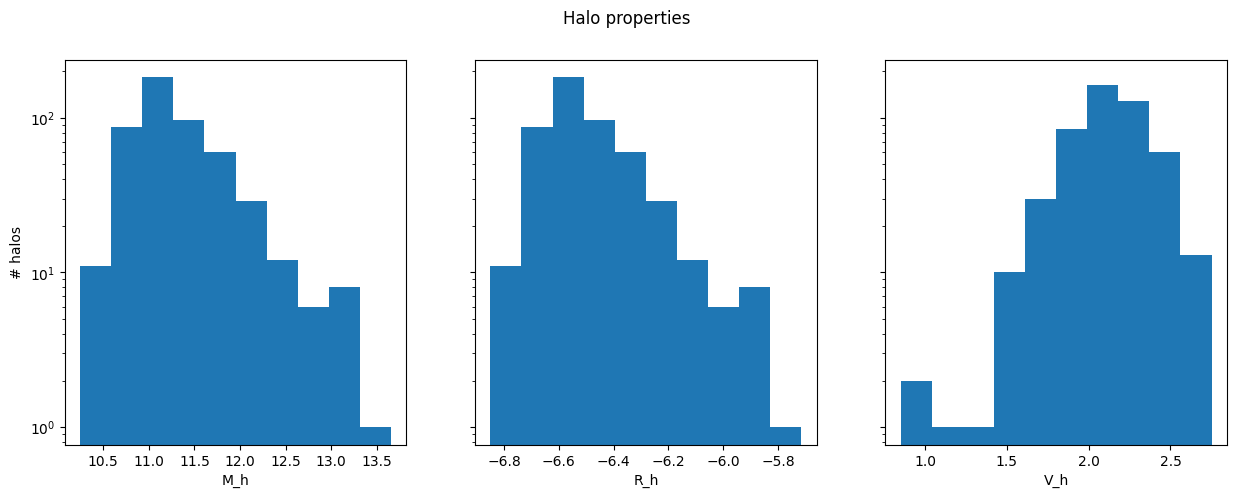

In [20]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True, dpi = 100)

fig.suptitle('Halo properties')

axs[0].hist(df['M_h'])
axs[0].set_yscale('log')
axs[0].set_xlabel('M_h')
axs[0].set_ylabel('# halos')

axs[1].hist(df['R_h'])
axs[1].set_yscale('log')
axs[1].set_xlabel('R_h')

axs[2].hist(df['V_h'])
axs[2].set_yscale('log')
axs[2].set_xlabel('V_h')

And stellar mass as:

Text(0.5, 1.0, 'Galaxy properties')

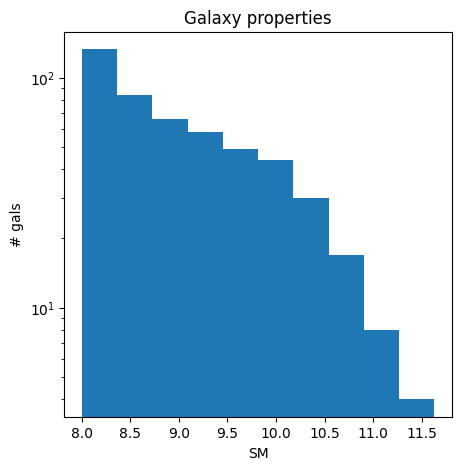

In [21]:
plt.figure(dpi = 100, figsize = (5, 5))
plt.hist(df['SM'])
plt.yscale('log')
plt.ylabel('# gals')
plt.xlabel('SM')
plt.title('Galaxy properties')

### 4.3) Measuring the correlation among halo/galaxy properties

Here we are going to measure the [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
\begin{equation}
 PCC = \frac{ \mathrm{cov} (X, Y) }{ \sigma_X \sigma_Y }
\end{equation}

and plot it as a heatmap of the values.

In [22]:
def correlation_heatmap(df):
    correlations = df.corr(method = 'pearson')

    fig, ax = plt.subplots(figsize = (10,10))
    sns.heatmap(correlations, vmax = 1.0, center = 0, fmt = '.6f',
                square = True, linewidths = .5, annot = True, 
                cbar_kws = {"shrink": .82})
    plt.title('Pearson correlation Heatmap')
    plt.show()
    
    return correlations

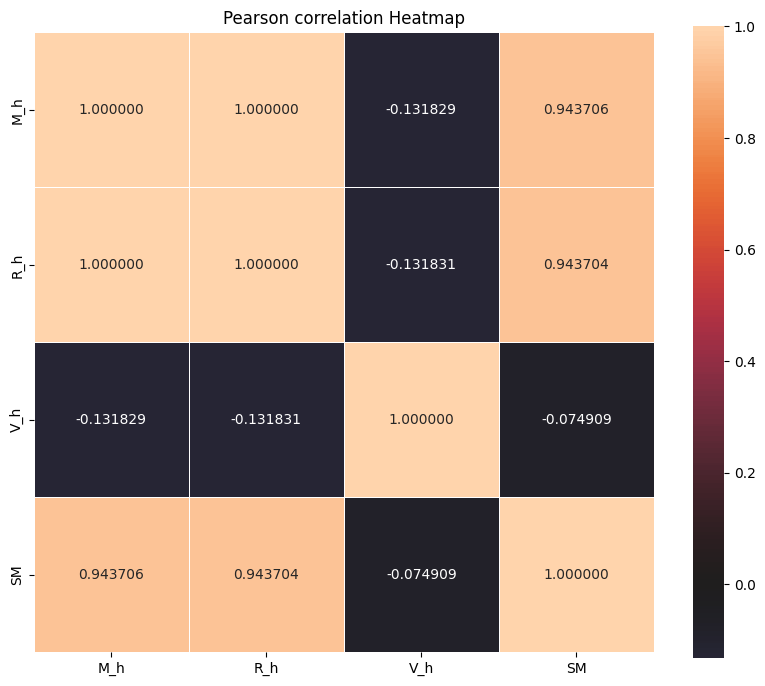

,M_h,R_h,V_h,SM
M_h,1.000000,1.000000,-0.131829,0.943706
R_h,1.000000,1.000000,-0.131831,0.943704
V_h,-0.131829,-0.131831,1.000000,-0.074909
SM,0.943706,0.943704,-0.074909,1.000000


In [23]:
correlation_heatmap(df)

In the above plot we can see:
* 1) The diagonal values are always $1$ (because they represent the correlation of each property with itself)
* 2) Halo masses and radius have a huge correlation to each other
* 3) Otherwise, halo velocities are not huge correlated with the other halo properties
* 4) Because we are interested to get galaxy properties, more specifically stellar mass from halo ones, we are interested in the correlation of them
* 5) Stellar Mass have the higher correlation with halo properties

### 4.4) Machine learning data-pre process:

First we need to select the input (X) and predicted features (y):

In [24]:
X = np.array([df['M_h'], df['R_h']]).T
y = np.array(df['SM'])
X.shape, y.shape

((493, 2), (493,))

Second, we need to split the data in **train** and **test** sets:

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Third, we can transform the data acconding to:
\begin{equation}
 data \Rightarrow \frac{(data - mean)}{std} .
\end{equation}
This transformation is done to constrain the range of all the input variables to small and similar values.

In [26]:
#Preparing data
mean_data = np.mean(X_train, axis = 0)
std_data = np.std(X_train, axis = 0)
mean_data, std_data

(array([11.31837815, -6.49310958]), array([0.50427504, 0.16809226]))

In [27]:
X_train -= mean_data
X_train /= std_data
X_test -= mean_data
X_test /= std_data

## 5) Neural Networks

A **neural network** is a collection of _nodes_ (neurons) that are arranged in a series of **layers**:

![](https://eu-images.contentstack.com/v3/assets/blt6b0f74e5591baa03/blt790f1b7ac4e04301/6543ff50fcf447040a6b8dc7/News_Image_(47).png?width=1280&auto=webp&quality=95&format=jpg&disable=upscale)
##### [Image source: [link](https://www.google.com/url?sa=i&url=https%3A%2F%2Faibusiness.com%2Fml%2Fhow-neural-networks-can-think-like-humans-and-why-it-matters&psig=AOvVaw0CldrZipLBRNpJUa3_epgA&ust=1731103284125000&source=images&cd=vfe&opi=89978449&ved=0CBQQjRxqFwoTCMjZ4rmcy4kDFQAAAAAdAAAAABAE)]

Each connection has a weight, $\omega_i a_i$, and each layer is a summarization of them, plus a bias $b$, according to:
\begin{equation}
 b_{\mu} + \sum_{\nu} W_{\mu \nu} a_{\nu} .
\end{equation}

Another numeric transformation called **activation function** is responsible for performing a non linear transformation of the values of each layer
\begin{equation}
 y_{\mu} = f \left( b_{\mu} + \sum_{\nu} W_{\mu \nu} a_{\nu} \right) ,
\end{equation}
This activation function can assume different forms:

![](https://miro.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png)
###### [Image source: [https://miro.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png](https://miro.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png)]

During the **training process** these _weights_ are adjusted through **epochs** in order to minimize the difference between the network predictions $y_{pred}$, and the target values $y_{target}$ through the minimization of a **loss function** (that also can assume different forms). In this tutorial we are going to use the **Mean Squared Error** (**MSE**)
\begin{equation}
 MSE = \frac{1}{m} \sum_{i = 1}^m (y_{pred} - y_{target})^2 ,
\end{equation}

### 5.1) Defining the model

Let's define a simple NN according to:

In [28]:
def base_model():
    model = models.Sequential() 
    model.add(layers.Dense(64, activation = 'relu', input_shape = (X_train.shape[1],)))
    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dense(1))
    
    print(model.summary())
    
    model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

And we can visualize the model, as well their details, instantiating the model:

In [29]:
my_model = base_model()
my_model

/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,305 (9.00 KB)

 Trainable params: 2,305 (9.00 KB)

 Non-trainable params: 0 (0.00 B)

None


<Sequential name=sequential, built=True>

### 5.2) Fitting the model

In [30]:
#Fitting data
no_epochs = 100
batch_size = 50
validation_split = 0.2
history = my_model.fit(X_train, y_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)
history

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 73.1453 - val_loss: 67.7406
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68.3110 - val_loss: 62.7250
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 62.9396 - val_loss: 57.4930
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.4960 - val_loss: 52.0145
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.0768 - val_loss: 46.2500
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 47.5190 - val_loss: 40.2304
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41.8730 - val_loss: 34.1090
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.8902 - val_loss: 28.3519
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.2956 - val_loss: 23.3560
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.6212 - val_loss: 19.3856
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.1620 - val_loss: 16.7255
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.4

To see if we don't have over/under fitting we can analyse the validation and training losses

In [31]:
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

Text(0.5, 0, 'Epochs')

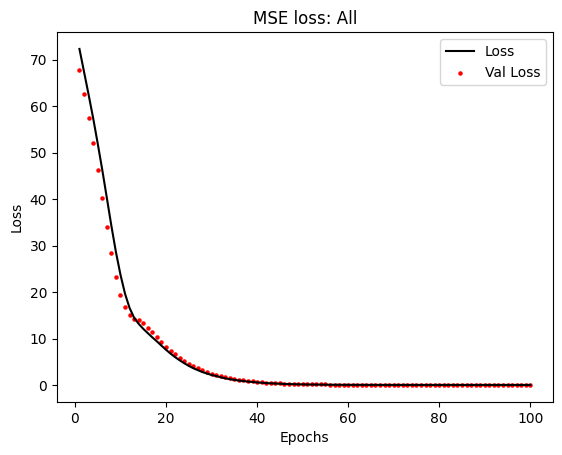

In [32]:
plt.figure(dpi=100)
plt.plot(epochs, train_loss, color = 'black',label = 'Loss')
plt.scatter(epochs, train_val_loss, s = 5, color = 'red', label = 'Val Loss')
plt.legend()  
plt.title('MSE loss: All')
plt.ylabel('Loss')
plt.xlabel('Epochs')

### 5.3) Predictions

In [33]:
#Prediction
prediction = my_model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


### 5.4) Checking for model performance

#### a) MSE

In [34]:
#Scores
MSE = mean_squared_error(prediction, y_test)
MSE

0.05377888392563858

#### b) Linear comparison

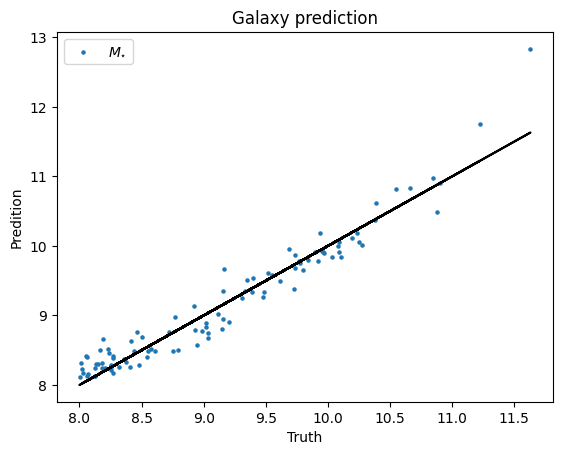

In [35]:
plt.figure(dpi = 100)
plt.title('Galaxy prediction')
plt.scatter(y_test, prediction, s = 5, color = 'C0', label = '$M_{\star}$')
plt.xlabel(r'Truth')
plt.plot(y_test, y_test, color = 'black')
plt.ylabel(r'Predition')
plt.legend()

#### c) Histogram of the complete distribution

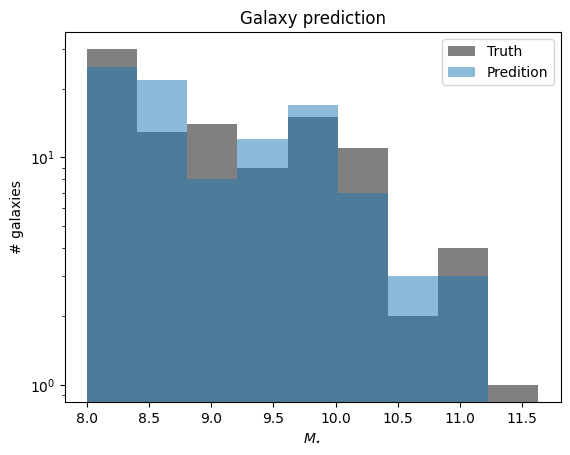

In [36]:
plt.figure(dpi = 100)
plt.title('Galaxy prediction')

bins = np.linspace(np.min(y_test), np.max(y_test), 10)
plt.hist(y_test, bins = bins, color = 'gray', label = 'Truth')
plt.hist(prediction, bins = bins, color = 'C0', alpha = 0.5, label = 'Predition')
plt.xlabel(r'$M_{\star}$')
plt.ylabel(r'# galaxies')
plt.legend()
plt.yscale('log')

Amazing! We have a way to predict stellar mass given halo properties!